In [45]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np

In [46]:
directory = 'CSVFile/FinancialData/Korea'

def financialReader(filename, directory):
    
    a = pd.read_csv(f"{directory}/NET_INCOME_KSE.csv", skiprows = 1)
    a['Code'] = pd.to_datetime(a['Code'].astype('str'), format='%Y%m') + MonthEnd()
    return a.set_index('Code')



## Net Income

In [49]:
## Cleansing AR
## Date => 'YYYY-MM-DD'

net_income = financialReader('NET_INCOME_KSE.csv', directory).shift(1).dropna(axis = 0, how = 'all')

In [58]:
def plus_to_nan(x):
    
    if x < 0: 
        return False
    elif x >= 0: 
        return True
    else:
        return np.nan

net_income_plus = net_income.applymap(plus_to_nan)

In [59]:
net_income_plus.head()

,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A298050,A298690,A300720,A306200,A900030,A900050,A900140,A950010,A950070,A950100
Code,,,,,,,,,,,,,,,,,,,,,
2000-06-30,True,NaN,True,False,True,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-30,False,True,False,False,False,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-31,True,True,False,False,True,NaN,True,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-31,False,True,False,False,False,False,True,False,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-30,True,True,True,True,True,True,True,False,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
## 적자기업 1년 투자
pr_directory = 'CSVFile/Price/Korea/Stocks'
price = pd.read_csv(f"{pr_directory}/KOSPI_FROM_1998_close.csv", index_col = 'D A T E', parse_dates=True).loc['2000-07-01':]
price.head()

,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A298050,A298690,A300720,A306200,A900030,A900050,A900140,A950010,A950070,A950100
D A T E,,,,,,,,,,,,,,,,,,,,,
2000-07-03,3665.0,1891,2730.0,7417,1644,469,11773,3290.0,NaN,17745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-04,3250.0,1922,2395.0,7342,1629,505,12151,3280.0,NaN,17996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-05,3735.0,1866,2750.0,7342,1619,495,11503,3190.0,NaN,17996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-06,3940.0,1836,2735.0,7642,1647,534,11341,3110.0,NaN,18800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-07,3895.0,1885,2730.0,7717,1644,546,11557,3120.0,NaN,19102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 주식 유니버스 선정

In [78]:
## Universe
none_invest = net_income_plus.isnull()
plus_invest = net_income_plus == True
minus_invest = (net_income_plus == False) & ~none_invest

In [141]:
data





{Timestamp('2000-06-30 00:00:00'): Index(['A000040', 'A000200', 'A000280', 'A000300', 'A000660', 'A000790',
        'A000800', 'A000890', 'A000910', 'A000980',
        ...
        'A017120', 'A017550', 'A018360', 'A018410', 'A018570', 'A025620',
        'A025840', 'A025890', 'A027390', 'A032640'],
       dtype='object', length=130),
 Timestamp('2000-09-30 00:00:00'): Index(['A000010', 'A000030', 'A000040', 'A000050', 'A000200', 'A000210',
        'A000280', 'A000300', 'A000650', 'A000660',
        ...
        'A018570', 'A023590', 'A024870', 'A025620', 'A025890', 'A027390',
        'A027970', 'A032640', 'A035150', 'A035510'],
       dtype='object', length=176),
 Timestamp('2000-12-31 00:00:00'): Index(['A000030', 'A000040', 'A000280', 'A000300', 'A000310', 'A000420',
        'A000490', 'A000720', 'A000760', 'A000790',
        ...
        'A025890', 'A025930', 'A026870', 'A027390', 'A032640', 'A034020',
        'A035150', 'A035250', 'A035720', 'A036460'],
       dtype='object', length=2

In [143]:
minus_data = {}
date_index = minus_invest.index

for date in date_index:

    minus_data[date] = (minus_invest.loc[date][minus_invest.loc[date] == True]).index

minus_data    

{Timestamp('2000-06-30 00:00:00'): Index(['A000040', 'A000200', 'A000280', 'A000300', 'A000660', 'A000790',
        'A000800', 'A000890', 'A000910', 'A000980',
        ...
        'A017120', 'A017550', 'A018360', 'A018410', 'A018570', 'A025620',
        'A025840', 'A025890', 'A027390', 'A032640'],
       dtype='object', length=130),
 Timestamp('2000-09-30 00:00:00'): Index(['A000010', 'A000030', 'A000040', 'A000050', 'A000200', 'A000210',
        'A000280', 'A000300', 'A000650', 'A000660',
        ...
        'A018570', 'A023590', 'A024870', 'A025620', 'A025890', 'A027390',
        'A027970', 'A032640', 'A035150', 'A035510'],
       dtype='object', length=176),
 Timestamp('2000-12-31 00:00:00'): Index(['A000030', 'A000040', 'A000280', 'A000300', 'A000310', 'A000420',
        'A000490', 'A000720', 'A000760', 'A000790',
        ...
        'A025890', 'A025930', 'A026870', 'A027390', 'A032640', 'A034020',
        'A035150', 'A035250', 'A035720', 'A036460'],
       dtype='object', length=2

In [136]:
data['2000-06-30']

KeyError: '2000-06-30'

In [144]:
## Quartarly Change

## invest Date
lag_invest_dates = list(minus_data.keys())[1:]
invest_dates = list(minus_data.keys())[:-1]

ret_data = pd.Series()

for cur_date, lag_date in zip(invest_dates, lag_invest_dates):
    
    ret_data = pd.concat([ret_data, (price.loc[cur_date:lag_date][minus_data[cur_date]].pct_change()).mean(axis = 1)])

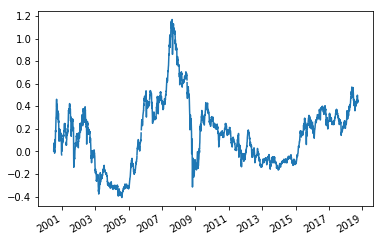

In [147]:
import matplotlib 

%matplotlib inline

ret_data.sub(-1).cumprod().sub(1).plot()